In [ ]:
!pip install -q tensorflow matplotlib scikit-learn

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools
from google.colab import drive
from IPython.display import FileLink

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Dataset path (update if different)
BASE_DIR = '/content/drive/MyDrive/datasets'
IMG_SIZE = (224, 224)   # EfficientNetB0 preferred size 224
BATCH_SIZE = 32
SEED = 123

In [ ]:
# Data generators (with validation split)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

valid_gen = valid_datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,   # important for metrics / confusion matrix
    seed=SEED
)

CLASS_INDICES = train_gen.class_indices
print('Class indices:', CLASS_INDICES)

Found 1613 images belonging to 2 classes.
Found 402 images belonging to 2 classes.
Class indices: {'ai_art': 0, 'human_art': 1}


In [ ]:
# Quick baseline CNN (you can skip if you want to focus on EfficientNet)
def make_simple_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

baseline = make_simple_cnn()
baseline.summary()

# Train baseline for a couple epochs (fast sanity check)
history_baseline = baseline.fit(train_gen, epochs=3, validation_data=valid_gen)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 729s 14s/step - accuracy: 0.5168 - loss: 4.1484 - val_accuracy: 0.6592 - val_loss: 0.6645
Epoch 2/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 249s 5s/step - accuracy: 0.7018 - loss: 0.5781 - val_accuracy: 0.6791 - val_loss: 0.6404
Epoch 3/3
51/51 ━━━━━━━━━━━━━━━━━━━━ 237s 5s/step - accuracy: 0.7711 - loss: 0.5083 - val_accuracy: 0.7164 - val_loss: 0.6103


In [ ]:
# Build EfficientNetB0 transfer-learning model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # freeze

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

effnet_model = models.Model(inputs, outputs)
effnet_model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
effnet_model.summary()

# Train top layers
history_eff_top = effnet_model.fit(train_gen, epochs=6, validation_data=valid_gen)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 233s 4s/step - accuracy: 0.8068 - loss: 0.3834 - val_accuracy: 0.8831 - val_loss: 0.2687
Epoch 2/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - accuracy: 0.9549 - loss: 0.1184 - val_accuracy: 0.8905 - val_loss: 0.3006
Epoch 3/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 211s 4s/step - accuracy: 0.9630 - loss: 0.0963 - val_accuracy: 0.9005 - val_loss: 0.3153
Epoch 4/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 212s 4s/step - accuracy: 0.9683 - loss: 0.0830 - val_accuracy: 0.9030 - val_loss: 0.2842
Epoch 5/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.9692 - loss: 0.0800 - val_accuracy: 0.9030 - val_loss: 0.3111
Epoch 6/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 260s 4s/step - accuracy: 0.9777 - loss: 0.0564 - val_accuracy: 0.9129 - val_loss: 0.3092


In [7]:
# Fine-tune: unfreeze some of the top layers of the base model
base_model.trainable = True

# Let's unfreeze from a specific layer
fine_tune_at = 100  # layer index to start fine-tuning (tweakable)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

effnet_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history_finetune = effnet_model.fit(train_gen, epochs=6, validation_data=valid_gen)

Epoch 1/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 394s 7s/step - accuracy: 0.8873 - loss: 0.2645 - val_accuracy: 0.9080 - val_loss: 0.2848
Epoch 2/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 303s 6s/step - accuracy: 0.9217 - loss: 0.1982 - val_accuracy: 0.9055 - val_loss: 0.2969
Epoch 3/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9507 - loss: 0.1346 - val_accuracy: 0.9055 - val_loss: 0.2904
Epoch 4/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 315s 6s/step - accuracy: 0.9555 - loss: 0.1148 - val_accuracy: 0.9104 - val_loss: 0.2770
Epoch 5/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 347s 7s/step - accuracy: 0.9685 - loss: 0.0898 - val_accuracy: 0.9104 - val_loss: 0.2765
Epoch 6/6
51/51 ━━━━━━━━━━━━━━━━━━━━ 310s 6s/step - accuracy: 0.9732 - loss: 0.0818 - val_accuracy: 0.9129 - val_loss: 0.2707


13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step
Confusion matrix:
 [[190  12]
 [ 23 177]]

Classification report:
              precision    recall  f1-score   support

      ai_art       0.89      0.94      0.92       202
   human_art       0.94      0.89      0.91       200

    accuracy                           0.91       402
   macro avg       0.91      0.91      0.91       402
weighted avg       0.91      0.91      0.91       402



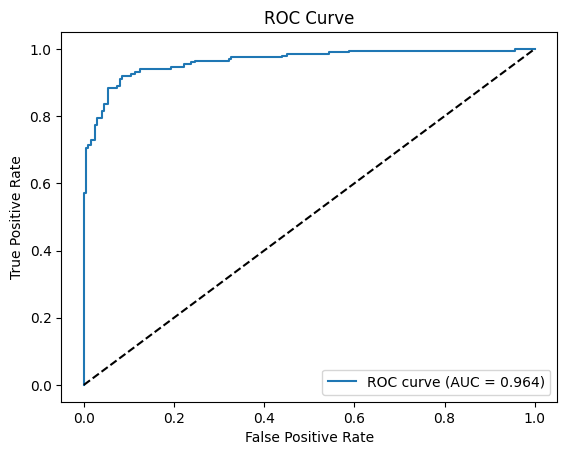

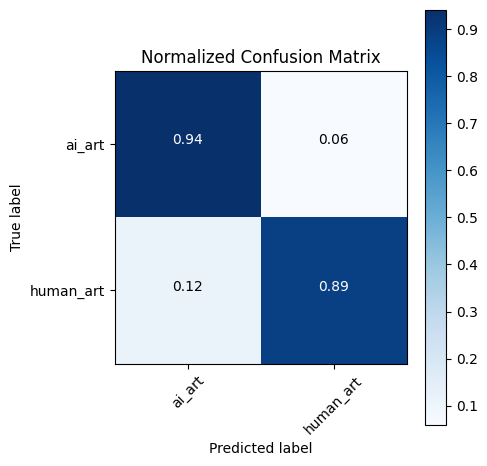

In [8]:
# Predictions on validation set
import numpy as np

valid_steps = valid_gen.samples // valid_gen.batch_size + int(valid_gen.samples % valid_gen.batch_size != 0)
preds = effnet_model.predict(valid_gen, steps=valid_steps)
y_pred_prob = preds.ravel()
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = valid_gen.classes[:len(y_pred)]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:\n', cm)

# Classification report
target_names = list(CLASS_INDICES.keys())
print('\nClassification report:')
print(classification_report(y_true, y_pred, target_names=target_names))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(5,5))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(cm, list(CLASS_INDICES.keys()), normalize=True, title='Normalized Confusion Matrix')

In [ ]:
# Grad-CAM explainability
import tensorflow.keras.backend as K
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, 0]  # binary
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, model, last_conv_layer_name='top_conv'):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_processed = preprocess_input(np.expand_dims(img_array, axis=0))
    heatmap = make_gradcam_heatmap(img_array_processed, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_array.astype('uint8'), 0.6, heatmap, 0.4, 0)
    out_path = '/content/gradcam_out.jpg'
    cv2.imwrite(out_path, superimposed_img)
    display(Image(out_path))
    return out_path

# Example usage: provide a valid image path in Drive
from IPython.display import Image, display
# out = save_and_display_gradcam('/content/drive/MyDrive/datasets/human_art/human_art (1).jpg', effnet_model)

Saving 047128c52456881ad6205b1403104029.jpg to 047128c52456881ad6205b1403104029.jpg

🔍 Analyzing: 047128c52456881ad6205b1403104029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


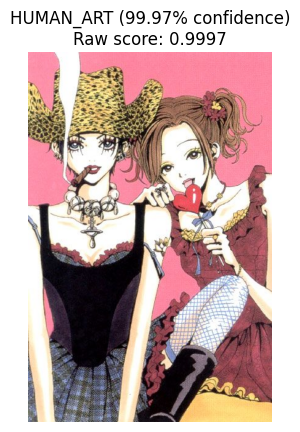

✅ Result: human_art
Confidence: 99.97%
Raw prediction score: 0.9997


In [47]:
from google.colab import files
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for fname in uploaded.keys():
    print(f"\n🔍 Analyzing: {fname}")

    # Load and preprocess image
    img = image.load_img(fname, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Predict
    pred = effnet_model.predict(img_array)[0][0]

    # Determine label
    class_names = {v: k for k, v in CLASS_INDICES.items()}
    predicted_class_idx = 1 if pred > 0.5 else 0
    predicted_label = class_names[predicted_class_idx]
    confidence = pred if pred > 0.5 else 1 - pred

    # Display results
    plt.imshow(image.load_img(fname))
    plt.axis("off")
    plt.title(f"{predicted_label.upper()} ({confidence:.2%} confidence)\nRaw score: {pred:.4f}")
    plt.show()

    print(f"✅ Result: {predicted_label}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Raw prediction score: {pred:.4f}")

In [62]:
%cd /content/drive/MyDrive/Colab\ Notebooks/IMGARD_PROJECT


/content/drive/MyDrive/Colab Notebooks/IMGARD_PROJECT


In [63]:
!jupyter nbconvert --to html IMGARD_TEST2.ipynb

[NbConvertApp] Converting notebook IMGARD_TEST2.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 411954 bytes to IMGARD_TEST2.html


In [66]:
from IPython.display import IFrame
IFrame('index.html', width=1000, height=600)